# ✈️ FlightOnTime — Predição de Atrasos em Voos

O **FlightOnTime** é um projeto de *Data Science* e *Back-End* voltado para prever a probabilidade de um voo **decolar no horário ou com atraso**, utilizando dados históricos de aviação civil.  
Ele faz parte de um desafio educacional cujo objetivo é construir um **MVP preditivo** capaz de apoiar passageiros, companhias aéreas e aeroportos na tomada de decisão.

## Descrição do projeto

### 🎯 Objetivo do Projeto

Criar um modelo de classificação binária que, a partir de informações de um voo — como companhia aérea, origem, destino, horário e distância — estima se ele será **Pontual (0)** ou **Atrasado (1)**, retornando também a probabilidade associada.

---

### 🧠 Pipeline de Data Science

O notebook conduz as principais etapas do fluxo de ciência de dados:

1. **ETL e limpeza dos dados**  
   - Carregamento, padronização e enriquecimento das informações de voos.

2. **Engenharia de variáveis (Feature Engineering)**  
   - Extração de atributos relevantes, como:  
     hora do voo, dia da semana, distância, aeroportos, companhia aérea.

3. **Modelagem preditiva**  
   - Testes com algoritmos supervisionados (ex.: Logistic Regression, Random Forest).

4. **Avaliação do modelo**  
   - Métricas como Acurácia, Precisão, Recall e F1-score.

5. **Exportação do modelo treinado**  
   - Serialização via `joblib` para uso pela API de Back-End.

---

### 🛠️ Integração com a API

O modelo gerado neste notebook será consumido por uma **API REST em Java (Spring Boot)**, que disponibilizará o endpoint:

```
POST /predict
```

Retornando:

```json
{
  "previsao": "Atrasado",
  "probabilidade": 0.78
}
```

---

### 📌 Sobre o Dataset

O projeto utiliza um conjunto de dados contendo informações reais de voos, incluindo:

- companhia aérea  
- aeroporto de origem e destino  
- data e horário de partida  
- distância do trecho  
- status de atraso  

As funções de ETL foram previamente desenvolvidas para garantir limpeza, consistência e rastreabilidade.

## 🚀 Início do Notebook

A partir daqui, o notebook executa o fluxo completo de preparação, análise e modelagem, resultando em um modelo leve, funcional e pronto para produção no MVP do FlightOnTime.

### Imports Globais

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from utils.parsers import parse_categoricals, parse_datetime, parse_int
from utils.plot_automl_results import plot_algorithm_selection, plot_adaptive_sampling, plot_feature_selection, plot_model_tuning

import automlx
from automlx import init # type: ignore

### Preprocessamento e Carga

Execute as funções abaixo para carregar os dados de fonte local ou para baixar, preprocessar e salvar os dados a partir da base de dados de vôos da ANAC (Agência Nacional de Aviação Civil).  
- Os dados são salvos em ./dados/  
- A função `processar_dados` acessa toda a base de dados da ANAC a partir de Janeiro/2018 até Outubro/2025.

In [3]:
def processar_dados(save: bool = True) -> pd.DataFrame:
    """
    Executa o pipeline completo de ETL dos dados de voos a partir da base de dados de vôos da ANAC (Agência Nacional de Aviação Civil).

    Baixa os arquivos CSV brutos, realiza o pré-processamento, consolida os dados
    em um único DataFrame e salva automaticamente os resultados em formatos
    CSV e Parquet no diretório ./data/, com versionamento por timestamp.

    Parâmetros
    ----------
    **save** : bool, opcional
        Indica se o DataFrame resultante deve ser salvo em disco.
        Padrão é True, o que significa que os arquivos serão salvos
        automaticamente.

    Retorna
    -------
    pd.DataFrame
        Dataset consolidado e pré-processado.
    """
    from etl.etl import getUrls, preprocess_csvs
        
    urls = getUrls()
    dataset = preprocess_csvs(urls)
    if save:
      from etl.etl import save_df
      save_df(dataset, timestamp=True)

    return dataset   


def carregar_dados(filename: str) -> pd.DataFrame:
    """
    Carrega um dataset de voos previamente pré-processado a partir de um arquivo Parquet
    e aplica conversões de tipo para colunas categóricas e de data/hora.

    Parâmetros
    ----------
    filename : str
        Nome-base do arquivo Parquet localizado em ./data/.
        Não inclua a extensão ".parquet".

    Retorna
    -------
    pd.DataFrame
        Dataset carregado com colunas categóricas convertidas para `category`
        e colunas de data/hora convertidas para `datetime`, pronto para análise
        ou modelagem.
    """
    
    filepath = f'{os.getcwd()}/data/{filename}.parquet'
    print(f"Carregando dataset local de: ./data/{filename}.parquet")
    dataset = pd.read_parquet(filepath)
    dataset = parse_categoricals(dataset)
    dataset = parse_datetime(dataset)
    dataset = parse_int(dataset)
    print("🏁 Dataset carregado com sucesso!")

    return dataset

#### Preprocessar com origem externa

Baixa e executa o preprocessamento em tempo de execução através da base de dados abertos da ANAC.  
Link: https://sistemas.anac.gov.br/dadosabertos/Voos%20e%20opera%C3%A7%C3%B5es%20a%C3%A9reas/Voo%20Regular%20Ativo%20%28VRA%29/  

Para mais informações sobre o processo, consulte a documentação do módulo etl.

In [4]:
# Código comentado por segurança
# Descomente a linha abaixo para executar o pipeline ETL completo

# df = processar_dados()

#### Preprocessar com origem local

Exemplo de nome de arquivo local:  
```python
filename = "dados_voos_20250101_153000"
```

- Não necessita informar o caminho do arquivo e extensão.  
- Caminho default: ./data
- Extensão default: .parquet

In [5]:
filename = "dados_voos_20260103_220419"
df = carregar_dados(filename=filename)

Carregando dataset local de: ./data/dados_voos_20260103_220419.parquet
🏁 Dataset carregado com sucesso!


#### Visualizações

In [6]:
df.head()

,Empresa Aérea,Código Tipo Linha,Aeródromo Origem,Aeródromo Destino,Distância (m),Data Hora Voo,Atrasado
0,AZU,R,SBRF,SBMO,181000,2018-01-01 13:50:00,0
1,AZU,R,SBCF,SBBR,591000,2018-01-01 17:30:00,0
2,AZU,R,SBCF,SBPA,1362000,2018-01-01 21:35:00,1
3,AZU,N,SBCY,SBPV,1145000,2018-01-01 12:15:00,0
4,AZU,N,SBPV,SBCY,1145000,2018-01-01 14:40:00,0


##### Verificando o tamanho do dataframe

In [7]:
df.shape

(3960369, 7)

##### Verificando os tipos das colunas

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960369 entries, 0 to 3960368
Data columns (total 7 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Empresa Aérea      category      
 1   Código Tipo Linha  category      
 2   Aeródromo Origem   category      
 3   Aeródromo Destino  category      
 4   Distância (m)      int32         
 5   Data Hora Voo      datetime64[ns]
 6   Atrasado           int8          
dtypes: category(4), datetime64[ns](1), int32(1), int8(1)
memory usage: 71.8 MB


#### Verificando ETL

In [9]:
def check_nulls(df: pd.DataFrame, col: str) -> None:
    nulls_notice = f'Coluna "{col}" possui {df[col].isna().sum()} valores nulos.'
    print(nulls_notice)
    return

def check_uniques(df: pd.DataFrame, col: str) -> None:
    print(f'Coluna "{col}":')
    print(f'{df[col].unique()}\n')
    return

##### Verificando Nulos

In [10]:
for col in df.columns:
    check_nulls(df, col)

Coluna "Empresa Aérea" possui 0 valores nulos.
Coluna "Código Tipo Linha" possui 0 valores nulos.
Coluna "Aeródromo Origem" possui 0 valores nulos.
Coluna "Aeródromo Destino" possui 0 valores nulos.
Coluna "Distância (m)" possui 0 valores nulos.
Coluna "Data Hora Voo" possui 0 valores nulos.
Coluna "Atrasado" possui 0 valores nulos.


##### Verificando Uniques

In [11]:
for col in df.columns:
    check_uniques(df, col)

Coluna "Empresa Aérea":
['AZU', 'GLO', 'ONE', 'TAM', 'PTB', ..., 'SID', 'IPM', 'OMI', 'ASO', 'ACN']
Length: 16
Categories (16, object): ['ACN', 'AMS', 'ASO', 'AZU', ..., 'SID', 'SUL', 'TAM', 'TTL']

Coluna "Código Tipo Linha":
['R', 'N']
Categories (2, object): ['N', 'R']

Coluna "Aeródromo Origem":
['SBRF', 'SBCF', 'SBCY', 'SBPV', 'SBCA', ..., 'SSBL', 'SNSS', 'SN6L', 'SNLN', 'SDOW']
Length: 220
Categories (220, object): ['SBAC', 'SBAE', 'SBAQ', 'SBAR', ..., 'SWPY', 'SWTP', 'SWTS', 'SWYN']

Coluna "Aeródromo Destino":
['SBMO', 'SBBR', 'SBPA', 'SBPV', 'SBCY', ..., 'SSBL', 'SN6L', 'SNSS', 'SNLN', 'SDOW']
Length: 219
Categories (219, object): ['SBAC', 'SBAE', 'SBAQ', 'SBAR', ..., 'SWPY', 'SWTP', 'SWTS', 'SWYN']

Coluna "Distância (m)":
[ 181000  591000 1362000 1145000 2454000  439000  649000  874000  533000
  627000  338000  363000 2620000 2106000  960000 1480000  343000  515000
  441000  496000 1692000 1122000 1186000  866000  914000  253000 1654000
  225000 1016000  845000  296000 22510

### Engenharia de Features

Nesta seção transformamos a coluna `Data Hora Voo` em features separadas:
- `Data do Voo` *datetime64[ns]*  
    - Data em que o vôo ocorreu.  

- `Horario_min` *int16*  
    - Horário do dia em que o vôo ocorreu em *minutos*.  
    *0 = 00:00, 1439 = 23:59*
- `Dia da Semana` *int8*  
    - Dia da semana em que o vôo ocorreu.  
    *0 = Segunda, 6 = Domingo* 

Por fim, eliminamos a original `Data Hora Voo`.

#### Data do Vôo

In [12]:
# Ativa o modo copy-on-write do pandas para evitar SettingWithCopyWarning
# pd.options.mode.copy_on_write = True

# df['Data do Voo'] = df['Data Hora Voo'].dt.date
# df['Data do Voo'] = pd.to_datetime(df['Data do Voo'], dayfirst=True, errors='coerce') # Transforma em Datetime

#### Horário do Vôo

In [13]:
# 0 = 0:00, 1439 = 23:59
# df['Horario_min'] = (
#     df['Data Hora Voo'].dt.hour * 60 + # type: ignore
#     df['Data Hora Voo'].dt.minute # type: ignore
# ).astype('int16')

#### Dia da Semana

In [14]:
# 0 = Segunda, 6 = Domingo
# df['Dia da Semana'] = df['Data Hora Voo'].dt.weekday.astype('int8') # type: ignore

In [15]:
df.shape

(3960369, 7)

### Visualizando (Y)

Aqui analisamos a distribuição dos vôos atrasados no histórico de vôos observados.  

- Aproximadamente 2.5 milhões de vôos foram pontuais.  
- Aproximadamente 1.4 milhões de vôos atrasaram, totalizando aproximadamente 35.45% dos vôos observados.  

In [16]:
def visualize_y(df: pd.DataFrame) -> None:
    from utils.plot_feature import plot_feature
    print(df['Atrasado'].value_counts())
    print(df['Atrasado'].value_counts(normalize=True))
    plot_feature(df, 'Atrasado')

Atrasado
0    2555413
1    1404956
Name: count, dtype: int64
Atrasado
0    0.645246
1    0.354754
Name: proportion, dtype: float64


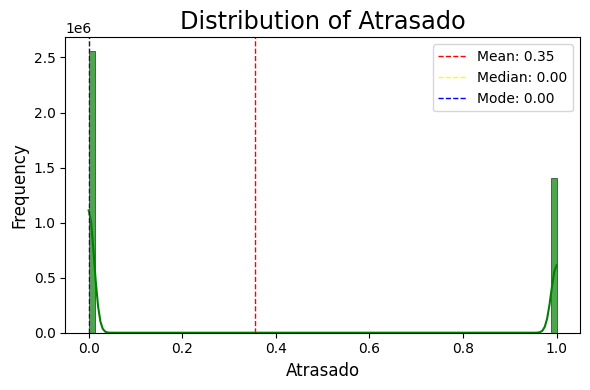

In [17]:
visualize_y(df)

### Separando X e Y

Aqui separaremos as features (X) da variável alvo (Y).

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Atrasado']),
    df['Atrasado'],
    test_size=0.3,
    random_state=42,
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2772258, 6), (1188111, 6), (2772258,), (1188111,))

In [19]:
X_train.head()

,Empresa Aérea,Código Tipo Linha,Aeródromo Origem,Aeródromo Destino,Distância (m),Data Hora Voo
539539,TAM,N,SBSG,SBGR,2296000,2020-01-20 12:45:00
3459606,GLO,N,SBSP,SBCF,524000,2025-03-09 19:25:00
483225,AZU,N,SBFZ,SBRF,627000,2018-12-27 06:50:00
355420,ONE,N,SBGR,SBRF,2101000,2018-10-29 23:20:00
1508305,TAM,N,SBGR,SBFZ,2347000,2022-07-10 09:30:00


In [20]:
y_train.head()

539539     0
3459606    0
483225     0
355420     0
1508305    0
Name: Atrasado, dtype: int8

### Modelagem

Para o processo de modelagem, decidimos usar a moderna biblioteca [Oracle AutoMLx](https://docs.oracle.com/en-us/iaas/tools/automlx/latest/latest/index.html), que automatiza os processos de `Seleção de Algoritmo`, `Sampling Adaptativo`, `Seleção de Features` e `Ajuste de Hiperparâmetros`, resultando num processo facilitado e com melhores métricas no modelo final.  

In [21]:
init(engine='local')

#### Referência de Pipeline:


Deletar depois **

```python
custom_pipeline = automlx.Pipeline(
    task='classification',
    model_list=[                 # Specify the models you want the AutoMLx to consider
        'LogisticRegression',
        'LGBMClassifier',
        'GaussianNB'
    ],
    n_algos_tuned=2,             # Choose how many models to tune
    min_features=[               # Specify minimum features to force the model to use. It can take 3 possible types of values:
        'native-country',        # If int, 0 < min_features <= n_features,
        'marital-status',              # If float, 0 < min_features <= 1.0, 1.0 means disabling feature selection
        'education-num'          # If list, names of features to keep, for example ['a', 'b'] means keep features 'a' and 'b'
    ],
    adaptive_sampling=False,     # Disable or enable Adaptive Sampling step. Default to `True`
    preprocessing=True,          # Disable or enable Preprocessing step. Default to `True`
    search_space={               # You can specify the hyper-parameters and ranges we search
        'LGBMClassifier': {
            'learning_rate': {'range': [0.01, 10], 'type': 'continuous'},
            'boosting_type': {'range': ['gbdt', 'dart'], 'type': 'categorical'},
        },
    },
    max_tuning_trials=2,         # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
    score_metric='f1_macro',     # Any scikit-learn metric or a custom function
)

est1 = custom_pipeline.fit(
    X_train,
    y_train,
    # X_val,
    # y_val,
    time_budget= 20,    # Specify time budget in seconds
    cv='auto'           # Automatically pick a good cross-validation (cv) strategy for the user's dataset.
                        # Ignored if X_valid and y_valid are provided.
                        # Can also be:
                        #   - An integer (For example, to use 5-fold cross validation)
                        #   - A list of data indices to use as splits (for advanced, such as time-based splitting)
)
```

In [22]:
# Referência de Pipeline:
# Deletar depois **

# custom_pipeline = automlx.Pipeline(
#     task='classification',
#     model_list=[                 # Specify the models you want the AutoMLx to consider
#         'LogisticRegression',
#         'LGBMClassifier',
#         'GaussianNB'
#     ],
#     n_algos_tuned=2,             # Choose how many models to tune
#     min_features=[               # Specify minimum features to force the model to use. It can take 3 possible types of values:
#         'native-country',        # If int, 0 < min_features <= n_features,
#         'marital-status',              # If float, 0 < min_features <= 1.0, 1.0 means disabling feature selection
#         'education-num'          # If list, names of features to keep, for example ['a', 'b'] means keep features 'a' and 'b'
#     ],
#     adaptive_sampling=False,     # Disable or enable Adaptive Sampling step. Default to `True`
#     preprocessing=True,          # Disable or enable Preprocessing step. Default to `True`
#     search_space={               # You can specify the hyper-parameters and ranges we search
#         'LGBMClassifier': {
#             'learning_rate': {'range': [0.01, 10], 'type': 'continuous'},
#             'boosting_type': {'range': ['gbdt', 'dart'], 'type': 'categorical'},
#         },
#     },
#     max_tuning_trials=2,         # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
#     score_metric='f1_macro',     # Any scikit-learn metric or a custom function
# )

# est1 = custom_pipeline.fit(
#     X_train,
#     y_train,
#     # X_val,            # Optionally, provide validation data to skip internal CV
#     # y_val,
#     time_budget= 20,    # Specify time budget in seconds
#     cv='auto'           # Automatically pick a good cross-validation (cv) strategy for the user's dataset.
#                         # Ignored if X_valid and y_valid are provided.
#                         # Can also be:
#                         #   - An integer (For example, to use 5-fold cross validation)
#                         #   - A list of data indices to use as splits (for advanced, such as time-based splitting)
# )

#### Pipeline

In [23]:
est1 = automlx.Pipeline(task='classification', score_metric='recall_macro') # type: ignore
est1.fit(X_train, y_train)

[2026-01-04 20:02:14,793] [automlx.interface] Dataset shape: (2772258,6)
[2026-01-04 20:02:14,954] [automlx.data_transform] Running preprocessing. Number of features: 7
[2026-01-04 20:02:16,088] [automlx.data_transform] Preprocessing completed. Took 1.134 secs
[2026-01-04 20:02:16,109] [automlx.process] Running Model Generation
[2026-01-04 20:02:16,132] [automlx] Provided model (TorchMLPClassifier) is not supported.Supported models are: ['CatBoostClassifier', 'LGBMClassifier', 'SVC', 'AdaBoostClassifier', 'DecisionTreeClassifier', 'ExtraTreesClassifier', 'GaussianNB', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'LinearSVC', 'LogisticRegressionClassifier', 'RandomForestClassifier', 'XGBClassifier']
[2026-01-04 20:02:16,133] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2026-01-04 20:02:16,134] [automlx.process] SVC is disabled. The SVC model is only recommende

### Avaliação do Modelo

In [24]:
def avaliar_modelo(estimator: automlx._interface.classifier.AutoClassifier) -> None: # type: ignore
    '''
        Calcula e exibe métricas de avaliação do modelo no conjunto de teste,
        incluindo ROC AUC, relatório de classificação e matriz de confusão
        normalizada.
        
        Parâmetros
        ----------
        estimator : automlx._interface.classifier.AutoClassifier
            - Estimador treinado pelo Oracle AutoMLx, utilizado para gerar predições e probabilidades sobre o conjunto de teste.

        Retorno
        -------
        None
    '''
    y_pred = estimator.predict(X_test)
    y_proba = estimator.predict_proba(X_test)

    cm = confusion_matrix(y_test.astype(int), y_pred, labels=[False, True])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Não Atrasou", "Atrasou"]
    )

    score_default = roc_auc_score(y_test, y_proba[:, 1])

    print(f'=> Roc_auc score em dados de teste:\n     {score_default}\n')
    print('=> Relatório de Classificação:\n')
    print(classification_report(y_test, y_pred))
    print('=> Matriz de Confusão:')
    disp.plot(cmap="viridis")

=> Roc_auc score em dados de teste:
     0.7001796736011552

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.77      0.63      0.69    766532
           1       0.49      0.65      0.56    421579

    accuracy                           0.64   1188111
   macro avg       0.63      0.64      0.63   1188111
weighted avg       0.67      0.64      0.65   1188111

=> Matriz de Confusão:


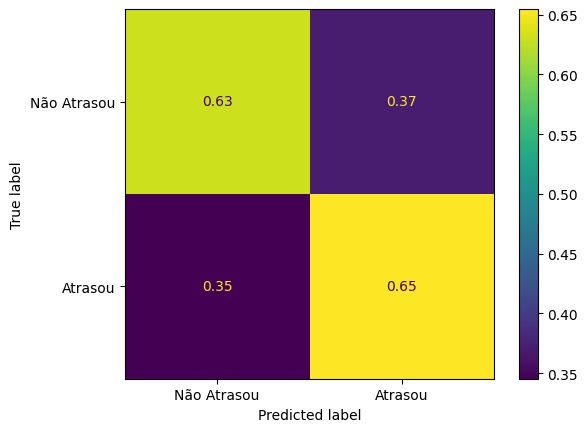

In [25]:
avaliar_modelo(est1)

### Análise do Processo de otimização do AutoMLx

Nesta seção analisamos o processo de otimização executado pelo AutoMLx de forma a compreender melhor o processo de modelagem e garantir a qualidade do resultado obtido.  

Para mais informações acesse:
- [Documentação do AutoMLx](https://docs.oracle.com/en-us/iaas/tools/automlx/latest/latest/index.html)  
- [Demo: AutoMLx Classification](https://github.com/oracle-samples/automlx/blob/main/demos/OracleAutoMLx_Classification.ipynb)

#### Sumário

Sumário dos experimentos executados pelo AutoMLx.

In [26]:
est1.print_summary()

""
"(2772258, 6)"
None
"HoldoutSplit(Shuffle=True, Seed=7, train portion=0.80)"
recall_macro
XGBClassifier
"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 6, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}"
25.3.1
"3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:16:04) [GCC 11.2.0]"


Step,# Samples,# Features,Algorithm,Hyperparameters,Score (recall_macro),All Metrics,Runtime (Seconds),Memory Usage (GB),Finished
Model Selection,4000,20,XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",0.5994,{'recall_macro': 0.5994382179826263},0.5675,0.7919,Sun Jan 4 20:02:20 2026
Model Selection,4000,20,LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}",0.5946,{'recall_macro': 0.5945626382948075},0.7063,0.7589,Sun Jan 4 20:02:20 2026
Model Selection,4000,20,RandomForestClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced'}",0.5611,{'recall_macro': 0.5611278054089526},1.4602,0.7739,Sun Jan 4 20:02:20 2026
Model Selection,4000,20,CatBoostClassifier,"{'iterations': 235, 'learning_rate': 0.787168, 'leaf_estimation_method': 'Newton', 'colsample_bylevel': 0.096865, 'depth': 3, 'l2_leaf_reg': 2.567326, 'feature_border_type': 'UniformAndQuantiles', 'model_size_reg': 3.85132, 'leaf_estimation_iterations': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'auto_class_weights': 'SqrtBalanced', 'allow_writing_files': False, 'allow_const_label': True}",0.5587,{'recall_macro': 0.5587310288533485},0.9281,0.8029,Sun Jan 4 20:02:19 2026
Model Selection,4000,20,ExtraTreesClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced', 'criterion': 'gini'}",0.5479,{'recall_macro': 0.5478535045354695},1.0802,0.7799,Sun Jan 4 20:02:20 2026
Model Selection,4000,20,DecisionTreeClassifier,"{'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 1.0, 'class_weight': None}",0.529,{'recall_macro': 0.5289733873775103},0.0989,0.7587,Sun Jan 4 20:02:19 2026
Model Selection,4000,20,GaussianNB,{},0.5194,{'recall_macro': 0.5194282947675046},0.0930,0.7585,Sun Jan 4 20:02:19 2026
Model Selection,4000,20,LogisticRegressionClassifier,"{'C': 1.0, 'solver': 'liblinear', 'class_weight': 'balanced'}",0.5,{'recall_macro': 0.5},0.1372,0.7668,Sun Jan 4 20:02:19 2026
Adaptive Sampling,80000,20,AdaptiveSamplingStage_XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",0.6317,{'recall_macro': 0.6317417988327613},0.9358,0.8339,Sun Jan 4 20:02:23 2026
Adaptive Sampling,64438,20,AdaptiveSamplingStage_XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",0.6271,{'recall_macro': 0.6271444214624651},1.2676,0.8285,Sun Jan 4 20:02:23 2026


#### Visualizações

Cada experimento (`trial`) nos gráficos abaixo é uma linha em um dataframe que contém:  
Algoritmo, Número de Amostras, Número de Features, Hiperparâmetros, Score, Tempo de Execução, Uso de Memória e Etapa.  

Para saber mais:
- [Acesse as funções](./utils/plot_automl_results.py)  

- Utilize o método `help()` para cada função.  
    <small>Exemplo: "help(plot_algorithm_selection)"</small>

##### Seleção de Algoritmo

Processo de seleção de algoritmo do AutoMLx.
- `Y`: Métrica
- `X`: Modelo

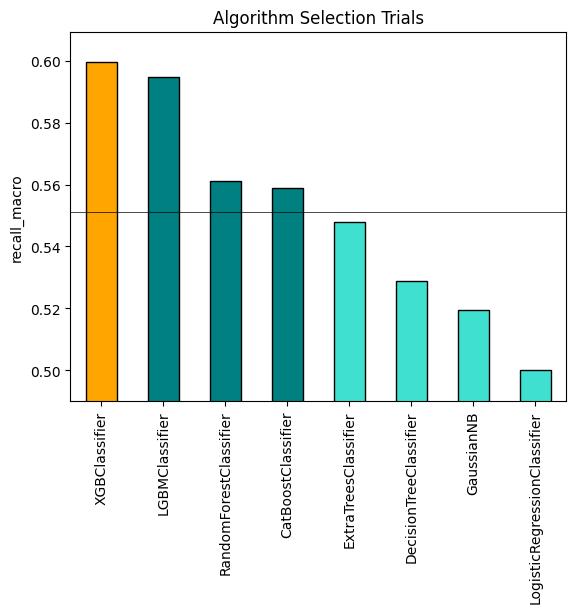

In [27]:
plot_algorithm_selection(est1)

##### Sampling Adaptativo

Processo de seleção de amostragem do AutoMLx.
- `Y`: Métrica
- `X`: Tamanho da Amostra

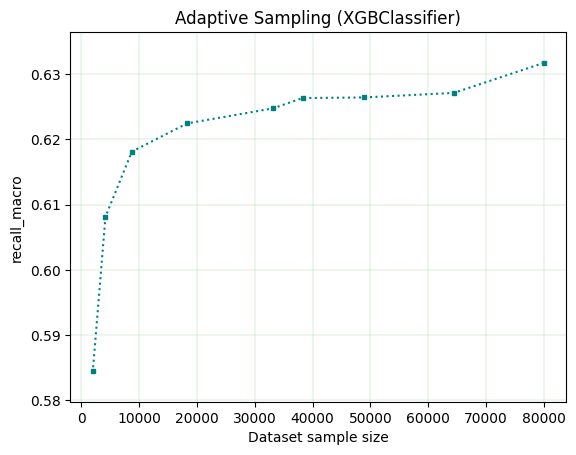

In [28]:
plot_adaptive_sampling(est1)

##### Seleção de Features

Processo de seleção de features do AutoMLx.
- `Y`: Métrica
- `X`: Número de features

Features selected: ['Aeródromo Destino', 'Aeródromo Origem', 'Data Hora Voo', 'Data Hora Voo__day', 'Data Hora Voo__hour', 'Data Hora Voo__midnight', 'Data Hora Voo__minute', 'Data Hora Voo__month', 'Data Hora Voo__weekday', 'Data Hora Voo__year', 'Distância (m)', 'Empresa Aérea']
Features dropped: ['Código Tipo Linha']


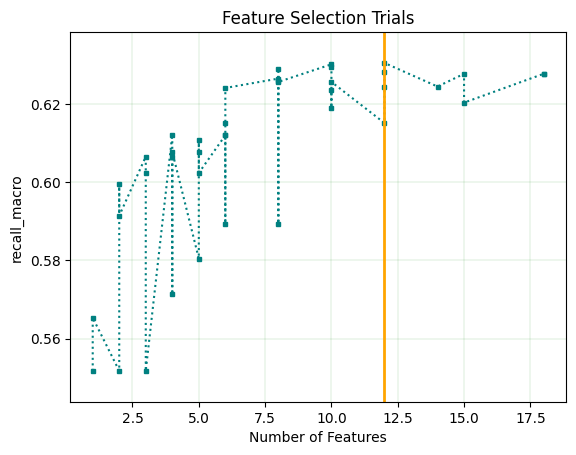

In [29]:
plot_feature_selection(est1, df.drop(columns=['Atrasado']))

##### Ajuste de Hiperparâmetros

Processo de seleção de hiperparâmetros do AutoMLx.
- `Y`: Métrica
- `X`: Iteração *n*

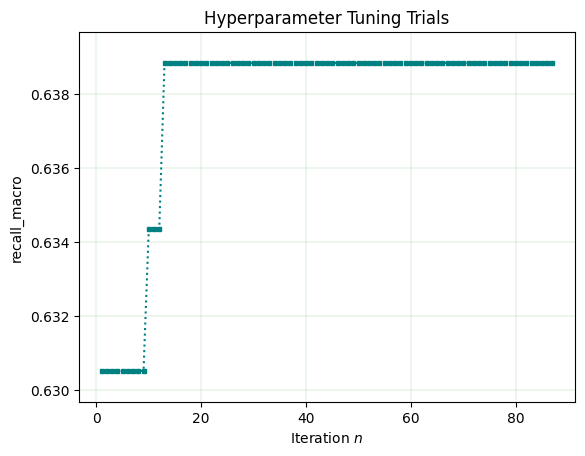

In [30]:
plot_model_tuning(est1)